<a href="https://colab.research.google.com/github/youssefbourais0310/Neural_Networks/blob/main/plant_meduim_data_mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
print(os.listdir("/content/drive/MyDrive/dataset_anass"))

['.DS_Store', 'small_data.csv', 'train', 'test']


In [138]:
import numpy as np
import pandas as pd
from keras.applications import xception
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
import tensorflow as tf
import datetime as dt
import random
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
import datetime
import tensorflow_hub as hub

In [5]:
CATEGORIES = ['Pelargonium_graveolens', 'Cirsium_arvense', 'Pelargonium_zonale', 'Mercurialis_annua', 'Phyllanthus_tenellus', 'Nephrolepis_exaltata', 'Vaccaria_hispanica',
              'Hyoseris_radiata']

NUM_CATEGORIES = len(CATEGORIES)
print(NUM_CATEGORIES)

8


In [55]:
SAMPLE_PER_CATEGORY = 400
data_dir = '/content/drive/MyDrive/dataset_anass'
train_dir = os.path.join(data_dir, '/content/drive/MyDrive/dataset_anass/train')
test_dir = os.path.join(data_dir, '/content/drive/MyDrive/dataset_anass/test')

In [11]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

Pelargonium_graveolens 331 images
Cirsium_arvense 276 images
Pelargonium_zonale 306 images
Mercurialis_annua 313 images
Phyllanthus_tenellus 103 images
Nephrolepis_exaltata 306 images
Vaccaria_hispanica 292 images
Hyoseris_radiata 144 images


In [175]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['/content/drive/MyDrive/dataset_anass/train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
# train.head()
train.shape
train

,file,category_id,category
0,/content/drive/MyDrive/dataset_anass/train/Pel...,0,Pelargonium_graveolens
1,/content/drive/MyDrive/dataset_anass/train/Pel...,0,Pelargonium_graveolens
2,/content/drive/MyDrive/dataset_anass/train/Pel...,0,Pelargonium_graveolens
3,/content/drive/MyDrive/dataset_anass/train/Pel...,0,Pelargonium_graveolens
4,/content/drive/MyDrive/dataset_anass/train/Pel...,0,Pelargonium_graveolens
...,...,...,...
2066,/content/drive/MyDrive/dataset_anass/train/Hyo...,7,Hyoseris_radiata
2067,/content/drive/MyDrive/dataset_anass/train/Hyo...,7,Hyoseris_radiata
2068,/content/drive/MyDrive/dataset_anass/train/Hyo...,7,Hyoseris_radiata
2069,/content/drive/MyDrive/dataset_anass/train/Hyo...,7,Hyoseris_radiata


In [64]:
train = pd.concat([train[train['category'] == c][:SAMPLE_PER_CATEGORY] for c in CATEGORIES])
train = train.sample(frac=1)
train.index = np.arange(len(train))
train.shape
train.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070],
           dtype='int64', length=2071)

In [84]:
test = []
for file in os.listdir(test_dir):
    test.append(['/content/drive/MyDrive/dataset_anass/test/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
test.head(2)
test.shape
test

,filepath,file
0,/content/drive/MyDrive/dataset_anass/test/Hyos...,Hyoseris_radiata
1,/content/drive/MyDrive/dataset_anass/test/Vacc...,Vaccaria_hispanica
2,/content/drive/MyDrive/dataset_anass/test/Neph...,Nephrolepis_exaltata
3,/content/drive/MyDrive/dataset_anass/test/Phyl...,Phyllanthus_tenellus
4,/content/drive/MyDrive/dataset_anass/test/Merc...,Mercurialis_annua
5,/content/drive/MyDrive/dataset_anass/test/Pela...,Pelargonium_zonale
6,/content/drive/MyDrive/dataset_anass/test/Cirs...,Cirsium_arvense
7,/content/drive/MyDrive/dataset_anass/test/Pela...,Pelargonium_graveolens


In [88]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

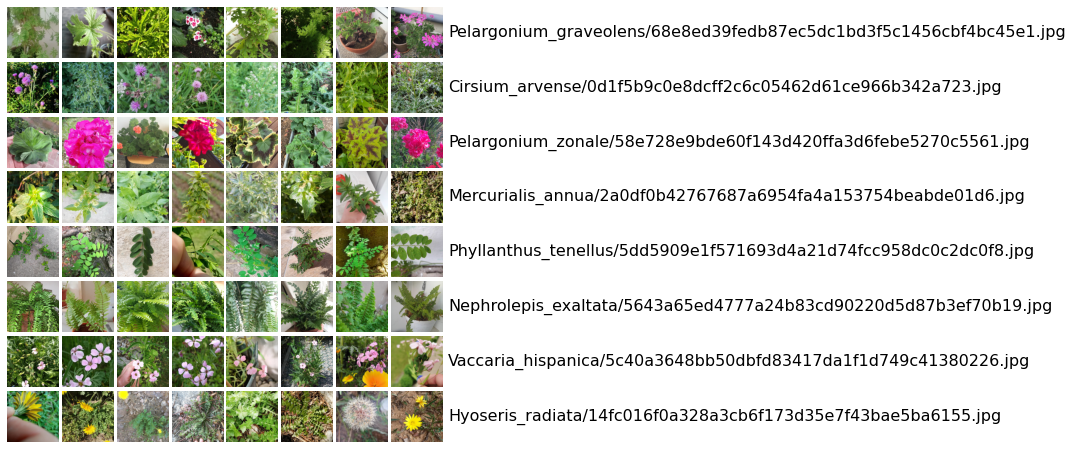

In [91]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (224, 224))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/content/drive/MyDrive/dataset_anass/train/')[1], verticalalignment='center')
        i += 1
plt.show()

In [92]:
np.random.seed(seed=42)
rnd = np.random.random(len(train))
train_idx = rnd <= 0.8
valid_idx = rnd > 0.8
ytr = train.loc[train_idx, 'category_id'].values
yv = train.loc[valid_idx, 'category_id'].values
len(ytr), len(yv)

(1656, 415)

In [97]:
from keras.applications.mobilenet import MobileNet,preprocess_input, decode_predictions
INPUT_SIZE=224
POOLING='avg'  #A pooling layer is another building block of a CNN. Pooling. Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network:The average value of all the pixels in the batch is selected.
x_train=np.zeros((len(train),INPUT_SIZE,INPUT_SIZE,3),dtype=np.float32)
for i,file in tqdm(enumerate(train['file'])):
    img = read_img(os.path.join(data_dir,file),(INPUT_SIZE,INPUT_SIZE))
    x=preprocess_input(np.expand_dims(img.copy(),axis=0)) #need to be changed for every model
    x_train[i]=x
print('Train image shape: {} size: {:,}'.format(x_train.shape,x_train.size))

2071it [00:14, 145.65it/s]

Train image shape: (2071, 224, 224, 3) size: 311,743,488


In [103]:
xtrain=x_train[train_idx]
xvalid=x_train[valid_idx]
print((xtrain.shape,xvalid.shape))

((1656, 224, 224, 3), (415, 224, 224, 3))


In [104]:
from keras.preprocessing import image
CNN_mobileNet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # MobileNet(include_top=False, weights=None, input_shape=(224, 224, 3))

In [105]:
train_CNN = CNN_mobileNet.predict(xtrain, batch_size=32, verbose=1)
valid_CNN = CNN_mobileNet.predict(xvalid, batch_size=32, verbose=1)
print('CNN train  features shape: {} size: {:,}'.format(train_CNN.shape, train_CNN.size))
print('CNN valid  features shape: {} size: {:,}'.format(valid_CNN.shape, valid_CNN.size))

13/13 [==============================] - 1s 81ms/step
CNN train  features shape: (1656, 7, 7, 1024) size: 83,091,456
CNN valid  features shape: (415, 7, 7, 1024) size: 20,823,040


In [106]:
train_CNN=train_CNN.reshape(1656,50176)
valid_CNN=valid_CNN.reshape(415,50176)

In [108]:
import keras
ytr_labels = tf.keras.utils.to_categorical(ytr, num_classes=8)
yv_labels = tf.keras.utils.to_categorical(yv, num_classes=8)

In [121]:
from keras.models import Sequential
from keras.layers import Dense, Activation
model=Sequential()

model.add(Dense(1000, input_dim=50176, activation='relu',kernel_initializer='uniform'))
keras.layers.core.Dropout(0.3, noise_shape=None, seed=None)

model.add(Dense(500,input_dim=1000,activation='sigmoid'))
keras.layers.core.Dropout(0.4, noise_shape=None, seed=None)

model.add(Dense(150,input_dim=500,activation='sigmoid'))
keras.layers.core.Dropout(0.2, noise_shape=None, seed=None)

model.add(Dense(units=8))
model.add(Activation('softmax'))


# model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
# model.summary()


 # compile the model 
model.compile(
              loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [110]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              50177000  
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dense_2 (Dense)             (None, 150)               75150     
                                                                 
 dense_3 (Dense)             (None, 8)                 1208      
                                                                 
 activation (Activation)     (None, 8)                 0         
                                                                 
Total params: 50,753,858
Trainable params: 50,753,858
Non-trainable params: 0
_________________________________________________________________


In [122]:
full_model = model.fit(train_CNN,ytr_labels, epochs=16, batch_size=32,validation_data=(valid_CNN, yv_labels))

Epoch 1/16
52/52 [==============================] - 1s 20ms/step - loss: 1.4730 - accuracy: 0.5429 - val_loss: 0.9949 - val_accuracy: 0.7783
Epoch 2/16
52/52 [==============================] - 1s 16ms/step - loss: 0.6891 - accuracy: 0.8219 - val_loss: 0.7102 - val_accuracy: 0.7639
Epoch 3/16
52/52 [==============================] - 1s 16ms/step - loss: 0.2789 - accuracy: 0.9348 - val_loss: 0.4318 - val_accuracy: 0.8530
Epoch 4/16
52/52 [==============================] - 1s 16ms/step - loss: 0.0807 - accuracy: 0.9873 - val_loss: 0.4046 - val_accuracy: 0.8795
Epoch 5/16
52/52 [==============================] - 1s 16ms/step - loss: 0.0262 - accuracy: 0.9970 - val_loss: 0.4475 - val_accuracy: 0.8675
Epoch 6/16
52/52 [==============================] - 1s 16ms/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.4446 - val_accuracy: 0.8747
Epoch 7/16
52/52 [==============================] - 1s 16ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.4541 - val_accuracy: 0.8723
Epoch 8/16
52

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


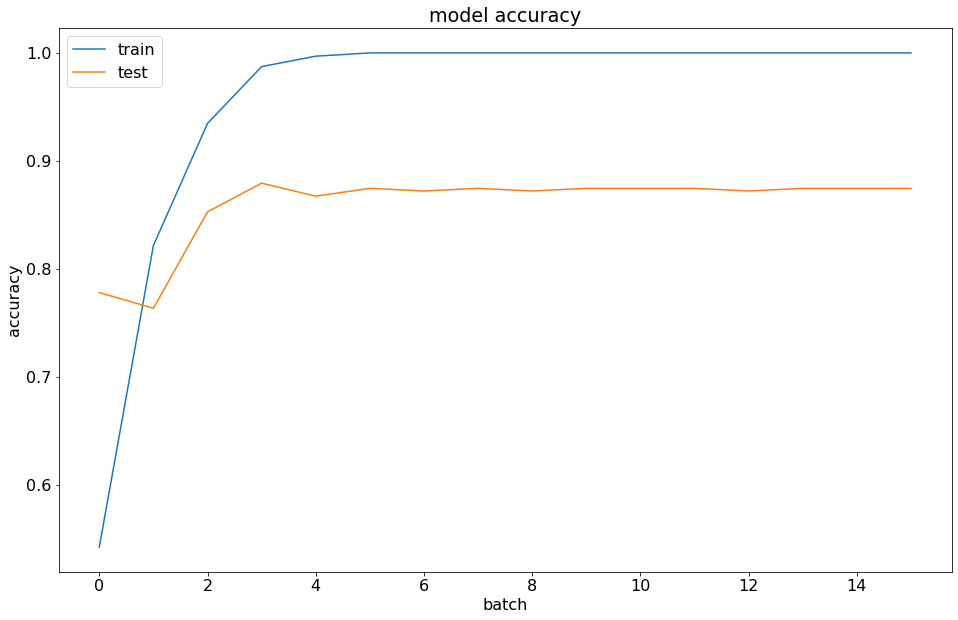

In [125]:
print(full_model.history.keys())
plt.plot(full_model.history['accuracy'])
plt.plot(full_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('batch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.save_weights('fc_model.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


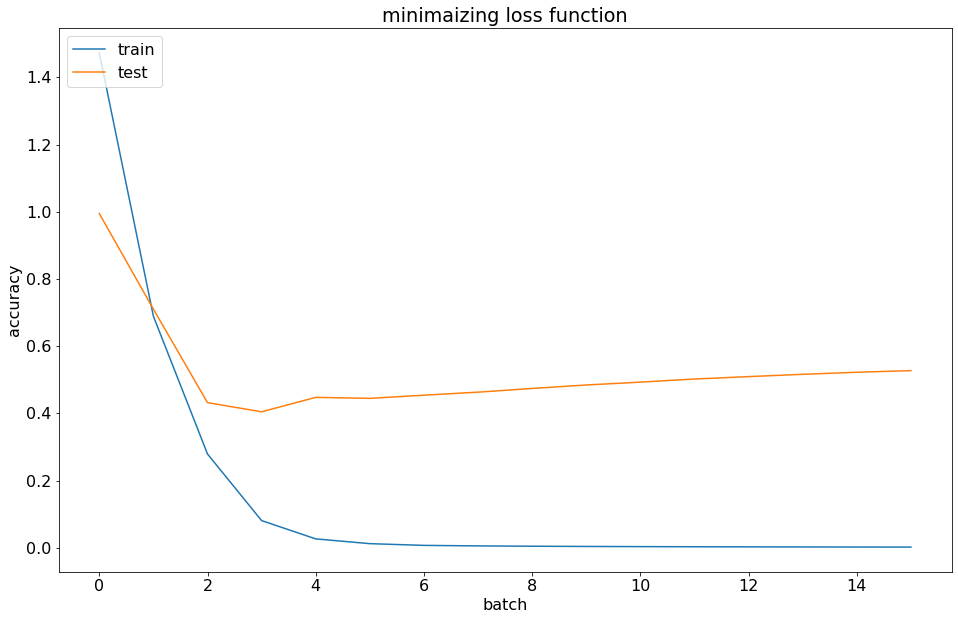

In [126]:
print(full_model.history.keys())
plt.plot(full_model.history['loss'])
plt.plot(full_model.history['val_loss'])
plt.title('minimaizing loss function')
plt.ylabel('accuracy')
plt.xlabel('batch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.save_weights('fc_model.h5')

In [127]:
# make a prediction on the validation data (not used to train on ) 
predictions = model.predict(valid_CNN, verbose=1)
predictions

13/13 [==============================] - 0s 5ms/step


array([[9.9831748e-01, 2.5725210e-04, 2.8314223e-04, ..., 2.9554096e-04,
        1.3620405e-04, 3.1475633e-04],
       [6.1485149e-02, 1.5491054e-03, 9.3145365e-01, ..., 1.3848090e-03,
        1.4544979e-03, 5.1452656e-04],
       [9.9829954e-01, 2.3558474e-04, 3.3015071e-04, ..., 2.6175193e-04,
        2.3401414e-04, 4.0718785e-04],
       ...,
       [3.6621594e-04, 3.0831178e-04, 1.4238794e-04, ..., 4.2470731e-04,
        7.4370526e-04, 9.9727553e-01],
       [9.9444515e-01, 1.0626889e-03, 4.7192143e-04, ..., 4.3495142e-04,
        3.0058896e-04, 2.5647357e-03],
       [4.3407173e-04, 1.7686919e-04, 4.4129838e-04, ..., 3.4454432e-03,
        1.1003523e-03, 6.9435779e-03]], dtype=float32)

In [128]:
predictions[1]

array([6.1485149e-02, 1.5491054e-03, 9.3145365e-01, 9.5026247e-04,
       1.2081035e-03, 1.3848090e-03, 1.4544979e-03, 5.1452656e-04],
      dtype=float32)

In [129]:
predictions.shape

(415, 8)

In [131]:
# first predction 
index = 414
print(predictions[index])
print(f"Max value (probability of prediction): { np.max(predictions[index])}")
print(f"Sum:{np.sum(predictions[index])}")
print(f"Max index : {np.argmax(predictions[index])}")
print(f"Predicted label:{CATEGORIES[np.argmax(predictions[index])]}")

[4.3407173e-04 1.7686919e-04 4.4129838e-04 6.2488834e-04 9.8683351e-01
 3.4454432e-03 1.1003523e-03 6.9435779e-03]
Max value (probability of prediction): 0.9868335127830505
Sum:1.0
Max index : 4
Predicted label:Phyllanthus_tenellus


In [142]:
CATEGORIES[4]

'Phyllanthus_tenellus'

## saving and reloading a trained model 

In [215]:
model.save('/content/drive/MyDrive/dataset_anass/models/mobilenet_CNN_meduim_data.h5')

In [217]:
 model_path ="/content/drive/MyDrive/dataset_anass/models/mobilenet_CNN_meduim_data.h5"
 model_load = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})

In [219]:
# load test image filenames
test_path = "/content/drive/MyDrive/dataset_anass/TEST"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['/content/drive/MyDrive/dataset_anass/TEST558b3146e1cc6479d6da058d24254fdeb8f02764.jpg',
 '/content/drive/MyDrive/dataset_anass/TEST244fb503cd2dcffda2fcdea05feb8c1e950a75c9.jpg',
 '/content/drive/MyDrive/dataset_anass/TESTb5a7465594beefbde215a63602fbd5610e657035.jpg',
 '/content/drive/MyDrive/dataset_anass/TESTebfb9dad7e556f200ee9c052911edeac1893dc64.jpg',
 '/content/drive/MyDrive/dataset_anass/TESTe58613834b346e862c484949c189abed92b59870.jpg',
 '/content/drive/MyDrive/dataset_anass/TESTd6b92eaa12a2f3ab70f2f063e385dac75de04ed9.jpg',
 '/content/drive/MyDrive/dataset_anass/TEST5894934fc3133baeb2d8b3714d5abe3ea06614a2.jpg',
 '/content/drive/MyDrive/dataset_anass/TEST269c6a563477855126ceeca40264bd3234c08f45.jpg',
 '/content/drive/MyDrive/dataset_anass/TEST88b176eae62ef6e5a35c313fd307ae163aff38dc.jpg',
 '/content/drive/MyDrive/dataset_anass/TEST53c5924de6e70b336e56d07758e2d481a2d4c188.jpg']

In [220]:
len(test_filenames)

599

In [297]:
# Define image size
IMG_SIZE = 224

#creat a funtion for preprocessing images

def process_image(image_path,img_size=IMG_SIZE) :
  """ 
  takes an image file path and turns the image into tensors.
  """
  # read an image file 
  image = tf.io.read_file(image_path)
  # turn the jpeg image into numerical tensors with 3 colour channels (red, green, blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size =[IMG_SIZE,IMG_SIZE])

  return image

In [298]:
# creat a simple function to return a tuple (image , label)
def get_image_label(image_path,label) : 

   """
   take an image file path name and assosciatd label,
   processes the image and return a typle of (image, label).
   """
   image = process_image(image_path)
   return image, label 

In [299]:
# define the batche size , 8 is a good start
BATCH_SIZE = 32

#creat a function to turn data into batches
def create_data_batches(X, y=None, batch_size = BATCH_SIZE, valid_data = False, test_data = False) :
  """
  create batches of data out of image (X) and label (y) pairs .
  shuffles the data if its training data but doesnt shuffle if its validation data.
  also accepts test data as input (no labels).
  """

  # if the data is a test dataset , we probably dont have labels
  if test_data :
    print("creating test data batches ...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch


  return data_batch

In [300]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data = True)

creating test data batches ...


In [301]:
test_data

<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [290]:
#make prdictions on test data batch using the loaded full model
test_predictions = model_load.predict(test_data,
                                             verbose = 1)

ValueError: ignored

Extra Work

In [212]:
# test1 = []
# for file in os.listdir(test_dir):
#     test1.append(['/content/drive/MyDrive/dataset_anass/test/{}'.format(file),file])
# test1=pd.DataFrame(test,columns=['file_path','file'])
# test1.tail()

,file_path,file
3,/content/drive/MyDrive/dataset_anass/test/Phyl...,Phyllanthus_tenellus
4,/content/drive/MyDrive/dataset_anass/test/Merc...,Mercurialis_annua
5,/content/drive/MyDrive/dataset_anass/test/Pela...,Pelargonium_zonale
6,/content/drive/MyDrive/dataset_anass/test/Cirs...,Cirsium_arvense
7,/content/drive/MyDrive/dataset_anass/test/Pela...,Pelargonium_graveolens


In [213]:
# x_test = np.zeros((len(test), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
# for i, file in tqdm(enumerate(test['file_path'])):
#     img = read_img(os.path.join(data_dir,file), (INPUT_SIZE, INPUT_SIZE))
#     x = preprocess_input(np.expand_dims(img.copy(), axis=0))
#     x_test[i] = x
# print('test Images shape: {} size: {:,}'.format(x_test.shape, x_test.size))

In [ ]:
# test_x_bf = vgg_bottleneck.predict(x_test, batch_size=32, verbose=1)
# print('Test bottleneck features shape: {} size: {:,}'.format(test_x_bf.shape, test_x_bf.size))


In [ ]:
# test_x_bf=test_x_bf.reshape(794,50176)

In [ ]:
# test_preds = model.predict(test_x_bf)

In [ ]:
# np.argmax(test_preds,axis=1).shape

In [ ]:
# test_pred_one = np.argmax(test_preds,axis=1)
# test['category_id'] = test_pred_one
# test['species'] = [CATEGORIES[c] for c in test_pred_one]
# test[['file', 'species']].to_csv('submission.csv', index=False)

In [ ]:
!ls